In [2]:
%matplotlib inline

In [152]:
#Generic imports
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sb
from rasterstats import zonal_stats

#Local imports
from specdal import Collection, Spectrum


<AxesSubplot:title={'center':'Micasense Filter + SVC measure'}, xlabel='wavelength', ylabel='Filter Transmissivity (%)'>

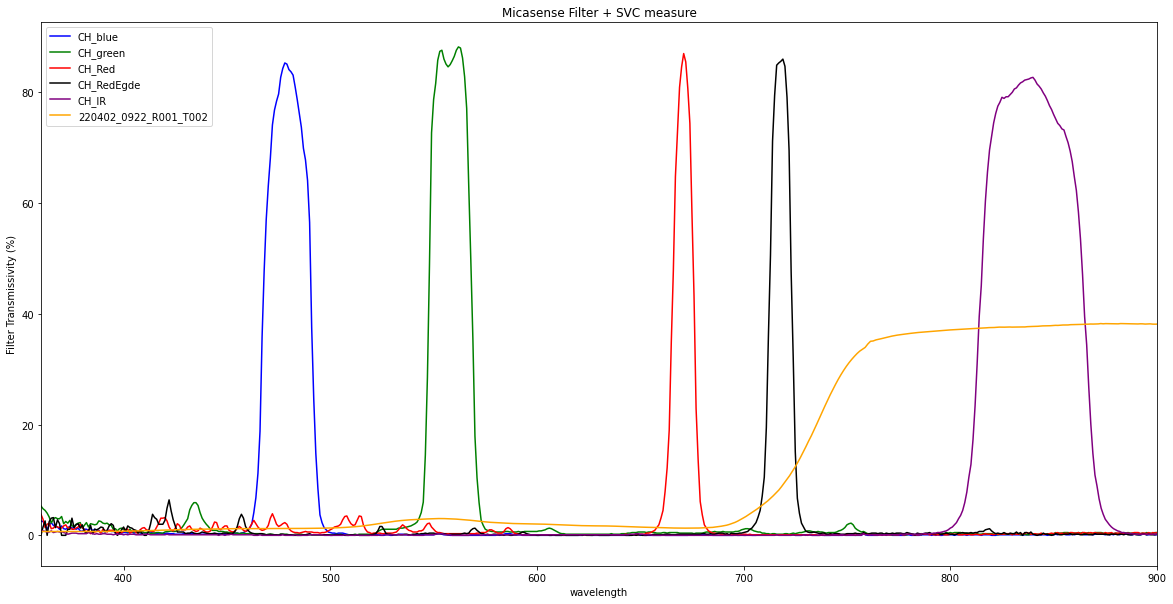

In [9]:
#Representar los filtros del azul, verde, rojo e infrarrojo
redEdge_filters = pd.read_csv('report_RedEdge_3_Filters_srs.csv',sep=';', index_col=0)
redEdge_filters_4_plot = redEdge_filters.replace("%", "", regex=True).astype(float)
redEdge_filters_numeric = (redEdge_filters.replace("%", "", regex=True).astype(float))/100

 #Create figure
legend_names = ['CH_blue','CH_green','CH_Red','CH_RedEgde','CH_IR']
ax = redEdge_filters_4_plot.iloc[:].plot(figsize=(20,10), color=['blue', 'green', 'red', 'black', 'purple'])
plt.legend(legend_names)
plt.title('Micasense Filter + SVC measure')
plt.ylabel('Filter Transmissivity (%)')
plt.xlabel('Wavelength (nm)')
plt.xlim(360, 900)
#plt.ylim(0,100)

(c.data['220402_0922_R001_T002']*100).plot(ax=ax, figsize=(20,10), c= 'orange',legend='SVC spectral')

In [6]:
datadir = "Z:/11-Projects/CERESTRES/04-Raw/SVC_HR1024i/Santaella/2022_04_02"
c = Collection(name='santaella_2022_04_02')
metadata = []
for f in sorted(os.listdir(datadir)):
    if f.endswith('.sig'):
        spectrum = Spectrum(filepath=os.path.join(datadir, f))
        c.append(spectrum)
        df = pd.DataFrame([spectrum.metadata])
        metadata.append(df)
df_metadata = pd.concat(metadata)

#Spectral data, transponeral para poder elegir las longitudes de onda.
df_spectral = c.data.transpose()

#Exportar a un CSV (df_metadata y data)
'''
df_metadata.to_csv(datadir+'/'+'metadata.csv', encoding='utf-8', index=False)
c.data.to_csv(datadir+'/'+'data.csv', encoding='utf-8')
'''

#Interpolación de todos los indices del dataframe
init_WV = 338
end_WV  = 2519
interval = 1
new_index = pd.Index(np.arange(init_WV,end_WV,interval))
df_interpolate = c.data.reindex(new_index).interpolate()

#df_interpolate.isna().sum()      #Check if there is NaN

<AxesSubplot:xlabel='wavelength'>

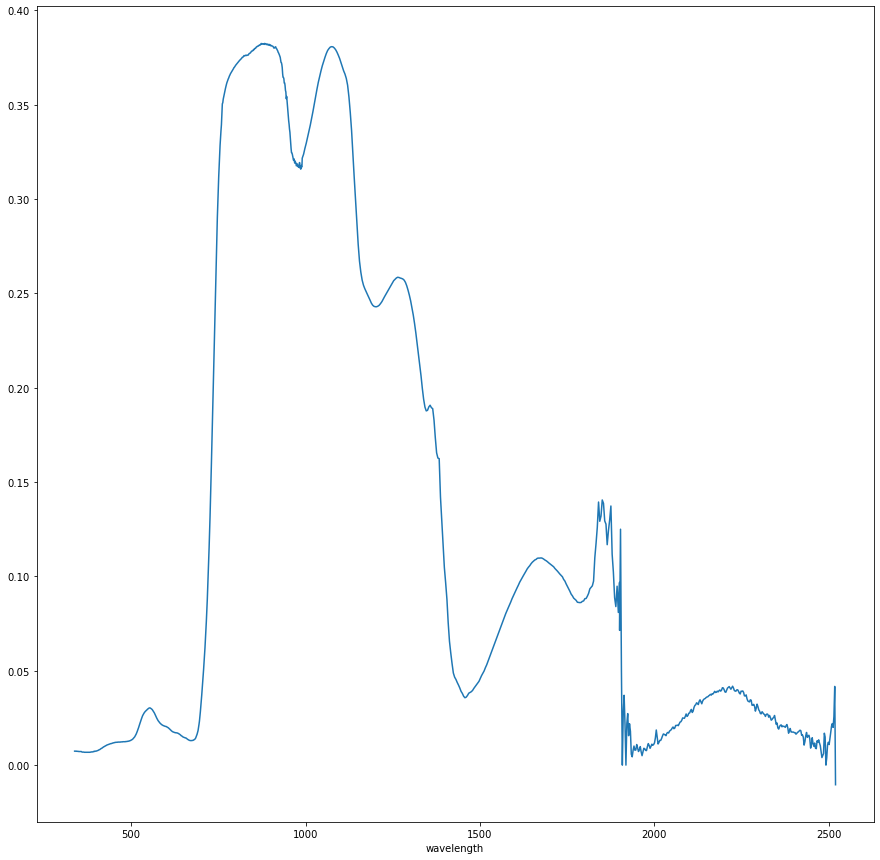

In [7]:
c.data['220402_0922_R001_T002'].plot(figsize=(15,15))

### Sumatorio de la radiancia para cada nivel de transmitancia - INDIVIDUAL

In [8]:
#Multiplicar los valores de radiancia del SVC por la ponderación que tiene la cámara del drone (Rededge MX) y dividirlo por el sumatorio del porcentaje de la transmitancia (ya que no está normalizado)
CH_blue_value_SVC = (redEdge_filters_numeric['Band 1']*df_interpolate.iloc[:,0]).dropna().sum()/redEdge_filters_numeric['Band 1'].sum()
CH_green_value_SVC = (redEdge_filters_numeric['Band 2']*df_interpolate.iloc[:,0]).dropna().sum()/redEdge_filters_numeric['Band 2'].sum()
CH_red_value_SVC = (redEdge_filters_numeric['Band 3']*df_interpolate.iloc[:,0]).dropna().sum()/redEdge_filters_numeric['Band 3'].sum()
CH_redEdge_value_SVC = (redEdge_filters_numeric['Band 5']*df_interpolate.iloc[:,0]).dropna().sum()/redEdge_filters_numeric['Band 5'].sum()
CH_infraRed_value_SVC = (redEdge_filters_numeric['Band 4']*df_interpolate.iloc[:,0]).dropna().sum()/redEdge_filters_numeric['Band 4'].sum()
#Index into a list
CH_value_SVC = np.array([CH_blue_value_SVC, CH_green_value_SVC, CH_red_value_SVC, CH_redEdge_value_SVC, CH_infraRed_value_SVC])
CH_value_SVC

array([0.01518053, 0.03533469, 0.02493815, 0.09018688, 0.37363588])

### Sumatorio de la radiancia para cada nivel de transmitancia - GRUPAL

In [118]:
# Create empty lists for indexing values
CH_blue = []
CH_green = []
CH_red = []
CH_rededge = []
CH_infrared= []

# Iterate for each measure file ['220402_0922_R001_T002']
for file in list(df_interpolate.columns):
    CH_blue_value_SVC = (redEdge_filters_numeric['Band 1']*df_interpolate[file]).dropna().sum()/redEdge_filters_numeric['Band 1'].sum()
    CH_green_value_SVC = (redEdge_filters_numeric['Band 2']*df_interpolate[file]).dropna().sum()/redEdge_filters_numeric['Band 2'].sum()
    CH_red_value_SVC = (redEdge_filters_numeric['Band 3']*df_interpolate[file]).dropna().sum()/redEdge_filters_numeric['Band 3'].sum()
    CH_redEdge_value_SVC = (redEdge_filters_numeric['Band 5']*df_interpolate[file]).dropna().sum()/redEdge_filters_numeric['Band 5'].sum()
    CH_infraRed_value_SVC = (redEdge_filters_numeric['Band 4']*df_interpolate[file]).dropna().sum()/redEdge_filters_numeric['Band 4'].sum()
    
    # Append values to list
    CH_blue.append(CH_blue_value_SVC)
    CH_green.append(CH_green_value_SVC)
    CH_red.append(CH_red_value_SVC)
    CH_rededge.append(CH_redEdge_value_SVC)
    CH_infrared.append(CH_infraRed_value_SVC)

# Create pandas dataframe with all channels
df_svc = pd.DataFrame(columns=['CH_blue_SVC','CH_green_SVC','CH_red_SVC','CH_redEdge_SVC','CH_infrared_SVC'], index=df_interpolate.columns)
df_svc['CH_blue_SVC'] = CH_blue
df_svc['CH_green_SVC'] = CH_green
df_svc['CH_red_SVC'] = CH_red
df_svc['CH_redEdge_SVC'] = CH_rededge
df_svc['CH_infrared_SVC'] = CH_infrared

## Extraer las medidas de los canales para cada plot

In [42]:
#shape_secano = gpd.read_file('C://Users/sergi/Documents/git_repos/00-CSIC/01-Plot_wheat_extract/01_shapefiles/plots_secano/secano_shapefile_full_atributes.shp').set_index('id_real')
svc_medidas_atributos = gpd.read_file('C://Users/sergi/Documents/git_repos/00-CSIC/01-Plot_wheat_extract/01_shapefiles/svc_medidas/svc_medidas_20220402.shp')
#Read tiff files for get MX index
blue_tiff = 'C://Users/sergi/Documents/git_repos/00-CSIC/01-Plot_wheat_extract/02_tiff_files/indices_MX/blue/Santaella_20220402_MX_index_blue.tif'
green_tiff = 'C://Users/sergi/Documents/git_repos/00-CSIC/01-Plot_wheat_extract/02_tiff_files/indices_MX/green/Santaella_20220402_MX_index_green.tif'
red_tiff = 'C://Users/sergi/Documents/git_repos/00-CSIC/01-Plot_wheat_extract/02_tiff_files/indices_MX/red/Santaella_20220402_MX_index_red.tif'
rededge_tiff = 'C://Users/sergi/Documents/git_repos/00-CSIC/01-Plot_wheat_extract/02_tiff_files/indices_MX/red_edge/Santaella_20220402_MX_index_red_edge.tif'
nir_tiff = 'C://Users/sergi/Documents/git_repos/00-CSIC/01-Plot_wheat_extract/02_tiff_files/indices_MX/nir/Santaella_20220402_MX_index_nir.tif'

In [121]:
stats_computed = 'mean max min median'
#Calculate zonal statistics of NDVI and join with shapefile atributes
df_blue_stats_MX = pd.DataFrame(zonal_stats(svc_medidas_atributos, blue_tiff, stats = stats_computed)).rename(columns={"min": "MX_min_BLUE", "max": "MX_max_BLUE", "mean": "MX_mean_BLUE", "median": "MX_median_BLUE"})
df_green_stats_MX = pd.DataFrame(zonal_stats(svc_medidas_atributos, green_tiff, stats = stats_computed)).rename(columns={"min": "MX_min_GREEN", "max": "MX_max_GREEN", "mean": "MX_mean_GREEN", "median": "MX_median_GREEN"})
df_red_stats_MX = pd.DataFrame(zonal_stats(svc_medidas_atributos, red_tiff, stats = stats_computed)).rename(columns={"min": "MX_min_RED", "max": "MX_max_RED", "mean": "MX_mean_RED", "median": "MX_median_RED"})
df_redegde_stats_MX = pd.DataFrame(zonal_stats(svc_medidas_atributos, rededge_tiff, stats = stats_computed)).rename(columns={"min": "MX_min_REDEDGE", "max": "MX_max_REDEDGE", "mean": "MX_mean_REDEDGE", "median": "MX_median_REDEDGE"})
df_nir_stats_MX = pd.DataFrame(zonal_stats(svc_medidas_atributos, nir_tiff, stats = stats_computed)).rename(columns={"min": "MX_min_NIR", "max": "MX_max_NIR", "mean": "MX_mean_NIR", "median": "MX_median_NIR"})

df_stats = svc_medidas_atributos.join(df_blue_stats_MX).join(df_green_stats_MX).join(df_red_stats_MX).join(df_redegde_stats_MX).join(df_nir_stats_MX)

In [126]:
df_stats.columns

Index(['id_real', 'fila_real', 'columna_re', 'id_josefin', 'tipo',
       'repeticion', 'numero_var', 'nombre_var', 'file', 'file_1',
       'instrument', 'integratio', 'measuremen', 'gps_time_r', 'gps_time_t',
       'longitude_', 'longitud_1', 'latitude_r', 'latitude_t', 'wavelength',
       'waveleng_1', 'ndvi', 'geometry', 'MX_min_BLUE', 'MX_max_BLUE',
       'MX_mean_BLUE', 'MX_median_BLUE', 'MX_min_GREEN', 'MX_max_GREEN',
       'MX_mean_GREEN', 'MX_median_GREEN', 'MX_min_RED', 'MX_max_RED',
       'MX_mean_RED', 'MX_median_RED', 'MX_min_REDEDGE', 'MX_max_REDEDGE',
       'MX_mean_REDEDGE', 'MX_median_REDEDGE', 'MX_min_NIR', 'MX_max_NIR',
       'MX_mean_NIR', 'MX_median_NIR'],
      dtype='object')

## Combinar los dataframe de SVC con el de la cámara

In [141]:
"""
INPUT:
    df_stats   --> MX camera
    df_svc  --> SVC
OUTPUT:
    df_stats_full --> Combining both dataframes
"""

#Set index for merging with the same index both
df_stats = df_stats.reset_index().set_index('file')
#Merging both dataframe
df_stats_full= pd.merge(df_stats, df_svc, left_index=True, right_index=True)
df_stats_full = df_stats_full.reset_index().set_index('id_real')
#Write into a csv file
df_stats_full.to_csv('df_stats_calibration_SVC_and_MX.csv')

## PLOTEAR LAS GRÁFICAS DE DISPERSIÓN

In [158]:
df_stats_full.columns

Index(['level_0', 'index', 'fila_real', 'columna_re', 'id_josefin', 'tipo',
       'repeticion', 'numero_var', 'nombre_var', 'file_1', 'instrument',
       'integratio', 'measuremen', 'gps_time_r', 'gps_time_t', 'longitude_',
       'longitud_1', 'latitude_r', 'latitude_t', 'wavelength', 'waveleng_1',
       'ndvi', 'geometry', 'MX_min_BLUE', 'MX_max_BLUE', 'MX_mean_BLUE',
       'MX_median_BLUE', 'MX_min_GREEN', 'MX_max_GREEN', 'MX_mean_GREEN',
       'MX_median_GREEN', 'MX_min_RED', 'MX_max_RED', 'MX_mean_RED',
       'MX_median_RED', 'MX_min_REDEDGE', 'MX_max_REDEDGE', 'MX_mean_REDEDGE',
       'MX_median_REDEDGE', 'MX_min_NIR', 'MX_max_NIR', 'MX_mean_NIR',
       'MX_median_NIR', 'CH_blue_SVC', 'CH_green_SVC', 'CH_red_SVC',
       'CH_redEdge_SVC', 'CH_infrared_SVC'],
      dtype='object')

In [172]:
from scipy import stats
def RMSE(df, p, x):
    return ((df[p] - df[x]) ** 2).mean() ** .5
    
def lregress(df, p, x):
    subset = df.dropna(subset=[p,x])
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset[x], subset[p])
    return(slope, intercept, r_value*r_value, p_value, std_err)

def validation_plot(x, y, data, title=None, x_label=None, y_label=None, alpha=.5, c=None, cmap='jet', ax=None, size=40):
    slope, intercept, r2, p_value, std_err = lregress(data, y, x)
    rmse = RMSE(data, y, x)
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    if c is None:
        data.plot.scatter(x=x, y=y, marker='.', alpha=alpha, ax=ax, s=size)
    else:
        data.plot.scatter(x=x, y=y, marker='.', alpha=alpha, c=c, cmap=cmap, ax=ax, s=size)
    min_val = min(data[x].min(), data[y].min())
    max_val = max(data[x].max(), data[y].max())
    ax.plot([min_val,max_val], [min_val,max_val], c='black')
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    val_text = "$r^2$: {r2:.5f}, slope: {slope:.2f}, intercept: {intercept:.5f}, RMSE: {rmse:.5f}".format(r2=r2, slope=slope, intercept=intercept, rmse=rmse)
    if title is None:
        ax.set_title("MX-drone ({x}) vs SVC ({y})\n{val}\n".format(x=x, y=y, val=val_text))
    else:
        ax.set_title(title)
    if x_label is not None:
        ax.set_xlabel(x_label)
    if y_label is not None:
        ax.set_ylabel(y_label)

In [175]:
df_stats_full.columns

Index(['level_0', 'index', 'fila_real', 'columna_re', 'id_josefin', 'tipo',
       'repeticion', 'numero_var', 'nombre_var', 'file_1', 'instrument',
       'integratio', 'measuremen', 'gps_time_r', 'gps_time_t', 'longitude_',
       'longitud_1', 'latitude_r', 'latitude_t', 'wavelength', 'waveleng_1',
       'ndvi', 'geometry', 'MX_min_BLUE', 'MX_max_BLUE', 'MX_mean_BLUE',
       'MX_median_BLUE', 'MX_min_GREEN', 'MX_max_GREEN', 'MX_mean_GREEN',
       'MX_median_GREEN', 'MX_min_RED', 'MX_max_RED', 'MX_mean_RED',
       'MX_median_RED', 'MX_min_REDEDGE', 'MX_max_REDEDGE', 'MX_mean_REDEDGE',
       'MX_median_REDEDGE', 'MX_min_NIR', 'MX_max_NIR', 'MX_mean_NIR',
       'MX_median_NIR', 'CH_blue_SVC', 'CH_green_SVC', 'CH_red_SVC',
       'CH_redEdge_SVC', 'CH_infrared_SVC'],
      dtype='object')

<AxesSubplot:xlabel='MX_median_NIR', ylabel='CH_infrared_SVC'>

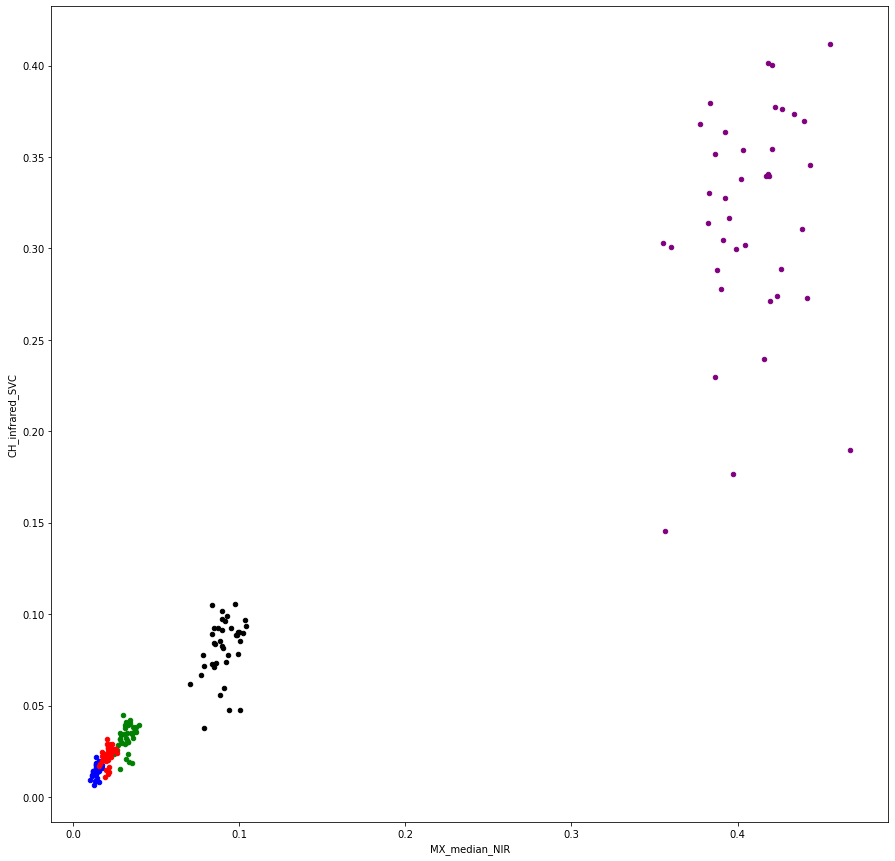

In [198]:
fig, axarr = plt.subplots(1,1, figsize=(15,15))
df_stats_full.plot.scatter('MX_median_BLUE', 'CH_blue_SVC', ax=axarr, c='blue')
df_stats_full.plot.scatter('MX_median_GREEN', 'CH_green_SVC', ax=axarr, alpha=1, c='green')
df_stats_full.plot.scatter('MX_median_RED', 'CH_red_SVC',  ax=axarr, alpha=1, c='red')
df_stats_full.plot.scatter('MX_median_REDEDGE', 'CH_redEdge_SVC', ax=axarr, alpha=1, c='k')
df_stats_full.plot.scatter('MX_median_NIR', 'CH_infrared_SVC',  ax=axarr, alpha=1, c='purple')


## Valores mediana

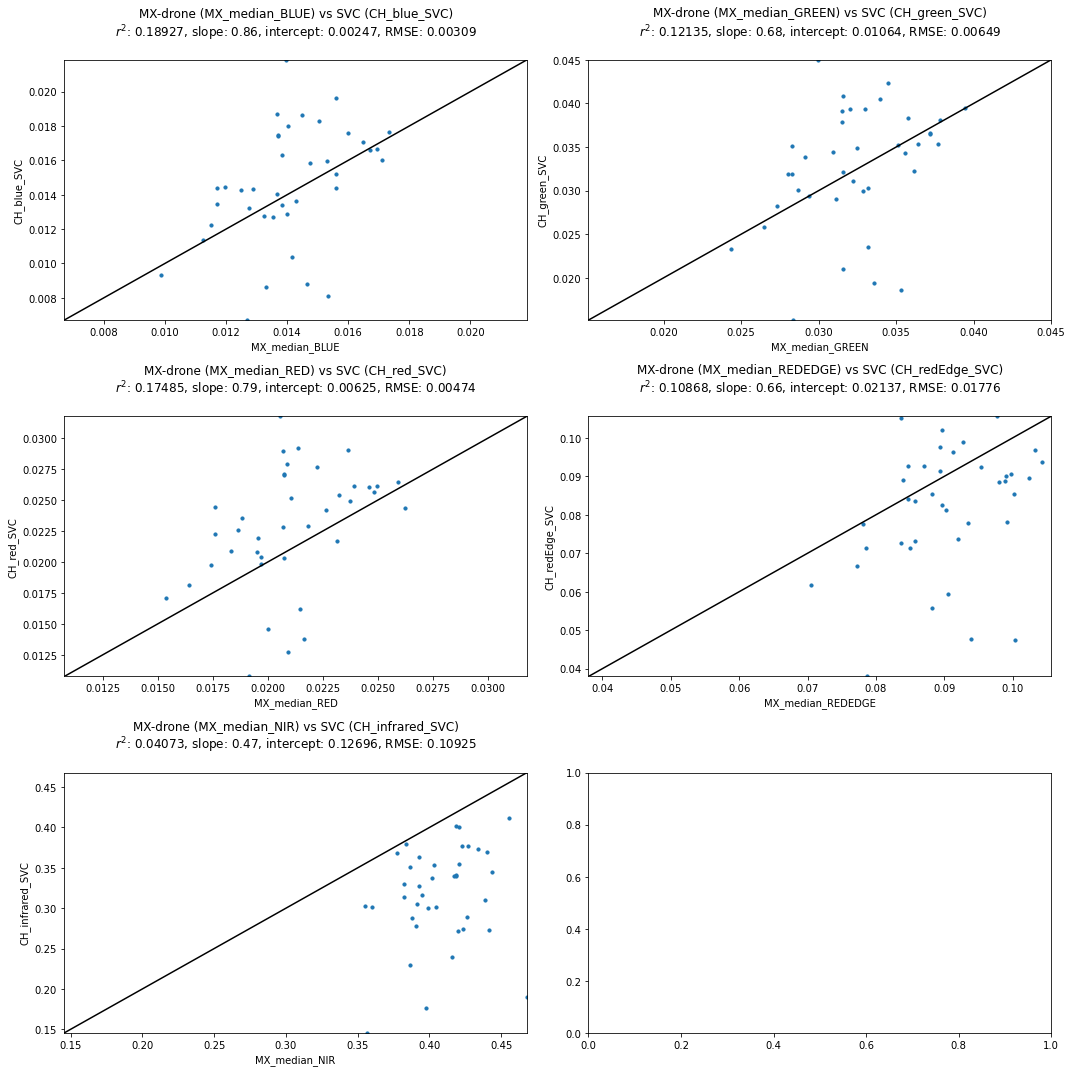

In [183]:
fig, axarr = plt.subplots(3,2, figsize=(15,15))
validation_plot('MX_median_BLUE', 'CH_blue_SVC',df_stats_full,  ax=axarr[0][0], alpha=1)
validation_plot('MX_median_GREEN', 'CH_green_SVC',df_stats_full, ax=axarr[0][1], alpha=1)
validation_plot('MX_median_RED', 'CH_red_SVC',df_stats_full,  ax=axarr[1][0], alpha=1)
validation_plot('MX_median_REDEDGE', 'CH_redEdge_SVC',df_stats_full, ax=axarr[1][1], alpha=1)
validation_plot('MX_median_NIR', 'CH_infrared_SVC',df_stats_full,  ax=axarr[2][0], alpha=1)
fig.tight_layout()


#sb.scatterplot(x=df_stats_full['MX_median_BLUE'], y=df_stats_full['CH_blue_SVC'], ax=axarr[0][0])
#sb.scatterplot(x=df_stats_full['MX_mean_BLUE'], y=df_stats_full['CH_blue_SVC'], ax=axarr[0][1])

## Valores medios

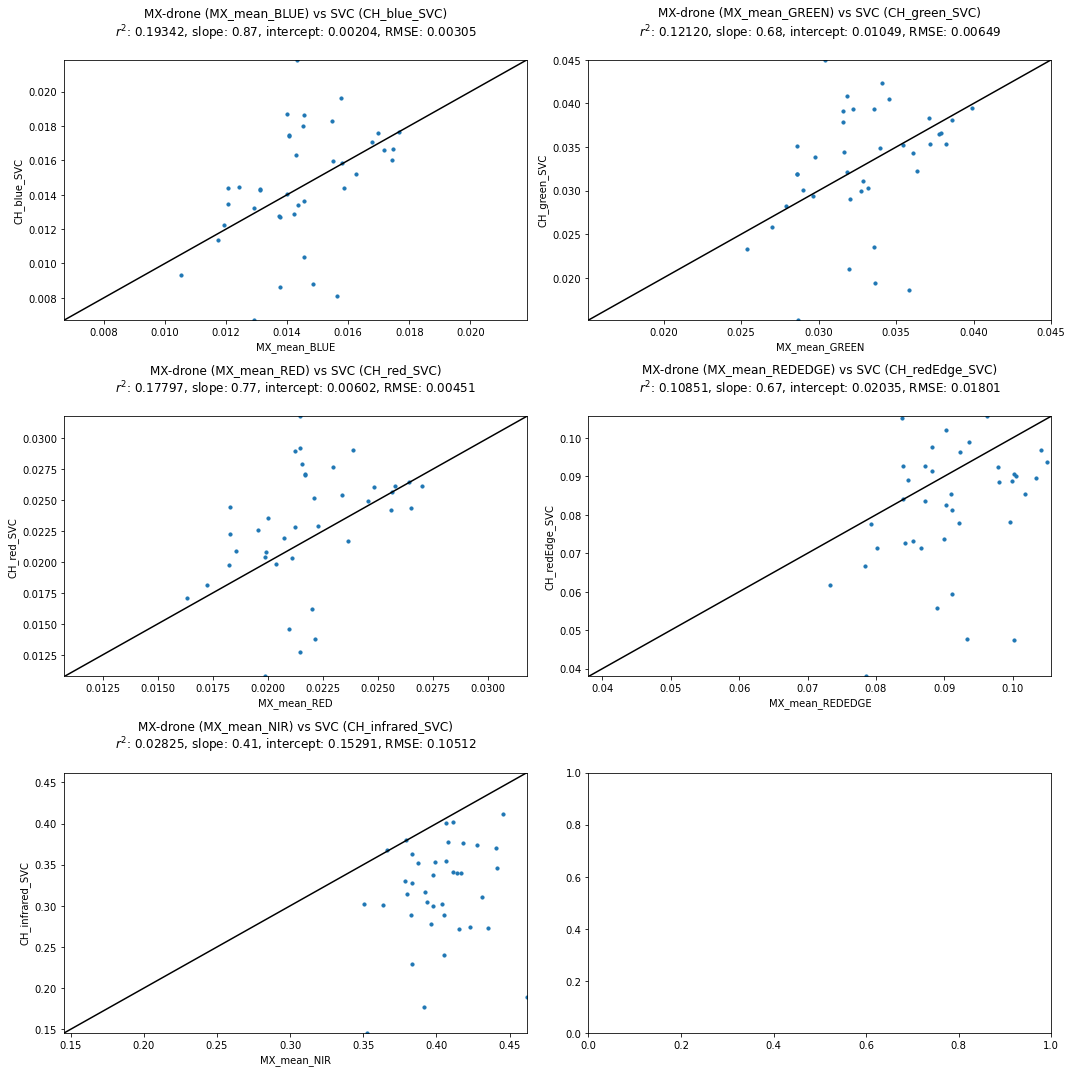

In [187]:
fig, axarr = plt.subplots(3,2, figsize=(15,15))
validation_plot('MX_mean_BLUE', 'CH_blue_SVC',df_stats_full,  ax=axarr[0][0], alpha=1)
validation_plot('MX_mean_GREEN', 'CH_green_SVC',df_stats_full, ax=axarr[0][1], alpha=1)
validation_plot('MX_mean_RED', 'CH_red_SVC',df_stats_full,  ax=axarr[1][0], alpha=1)
validation_plot('MX_mean_REDEDGE', 'CH_redEdge_SVC',df_stats_full, ax=axarr[1][1], alpha=1)
validation_plot('MX_mean_NIR', 'CH_infrared_SVC',df_stats_full,  ax=axarr[2][0], alpha=1)
fig.tight_layout()

## Valores máximos

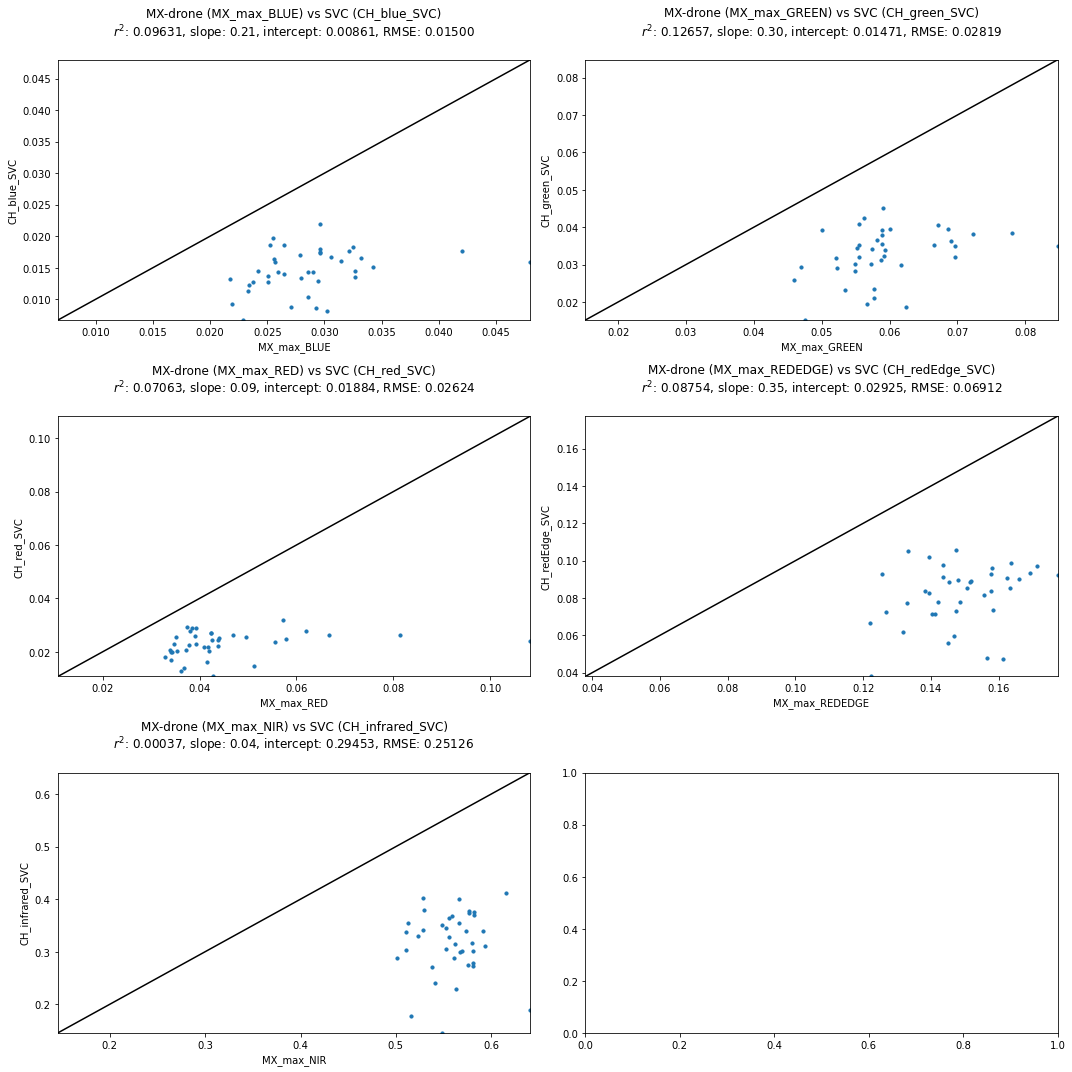

In [185]:
fig, axarr = plt.subplots(3,2, figsize=(15,15))
validation_plot('MX_max_BLUE', 'CH_blue_SVC',df_stats_full,  ax=axarr[0][0], alpha=1)
validation_plot('MX_max_GREEN', 'CH_green_SVC',df_stats_full, ax=axarr[0][1], alpha=1)
validation_plot('MX_max_RED', 'CH_red_SVC',df_stats_full,  ax=axarr[1][0], alpha=1)
validation_plot('MX_max_REDEDGE', 'CH_redEdge_SVC',df_stats_full, ax=axarr[1][1], alpha=1)
validation_plot('MX_max_NIR', 'CH_infrared_SVC',df_stats_full,  ax=axarr[2][0], alpha=1)
fig.tight_layout()

## Valores mínimos

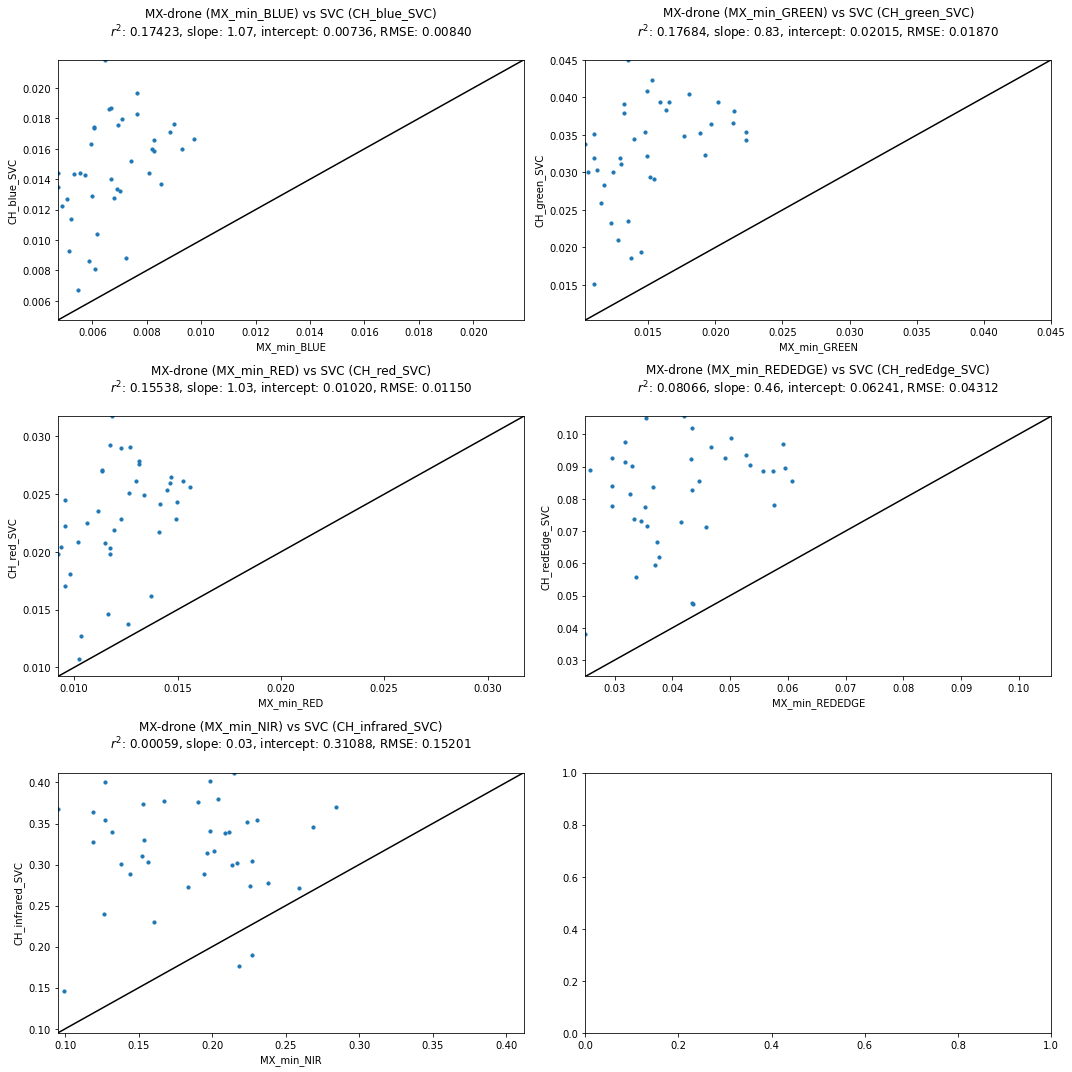

In [186]:
fig, axarr = plt.subplots(3,2, figsize=(15,15))
validation_plot('MX_min_BLUE', 'CH_blue_SVC',df_stats_full,  ax=axarr[0][0], alpha=1)
validation_plot('MX_min_GREEN', 'CH_green_SVC',df_stats_full, ax=axarr[0][1], alpha=1)
validation_plot('MX_min_RED', 'CH_red_SVC',df_stats_full,  ax=axarr[1][0], alpha=1)
validation_plot('MX_min_REDEDGE', 'CH_redEdge_SVC',df_stats_full, ax=axarr[1][1], alpha=1)
validation_plot('MX_min_NIR', 'CH_infrared_SVC',df_stats_full,  ax=axarr[2][0], alpha=1)
fig.tight_layout()

# NO MIRAR, SON PRUEBAS

In [43]:
ch_blue = (redEdge_filters_numeric['Band 1']*df_interpolate.iloc[:,0]).dropna().sum()

In [36]:
ch_blue_clean = ch_blue.dropna()

In [44]:
ch_blue

0.2996635996097519

In [21]:
redEdge_filters_numeric

Band 1  Band 2  Band 3  Band 5  Band 4
Wavlength (nm)                                        
360              0.026   0.053   0.038   0.000   0.009
361              0.025   0.048   0.029   0.015   0.008
362              0.018   0.045   0.014   0.026   0.007
363              0.011   0.040   0.020   0.000   0.006
364              0.018   0.033   0.022   0.025   0.006
...                ...     ...     ...     ...     ...
896              0.001   0.004   0.005   0.002   0.002
897              0.002   0.004   0.003   0.001   0.002
898              0.002   0.003   0.005   0.001   0.002
899              0.001   0.005   0.004   0.001   0.002
900              0.001   0.005   0.005   0.002   0.002

[541 rows x 5 columns]

In [26]:
df_interpolate.iloc[:,0]

338     0.007400
339     0.007377
340     0.007355
341     0.007332
342     0.007309
          ...   
2514    0.016900
2515    0.016900
2516    0.016900
2517    0.016900
2518    0.016900
Name: 220402_0922_R001_T002, Length: 2181, dtype: float64

In [ ]:
redEdge_filters = pd.read_csv('report_RedEdge_3_Filters_srs.csv',sep=';', index_col=0)
redEdge_filters_trans = redEdge_filters.transpose()
redEdge_filters_trans = redEdge_filters_trans.replace("%", "", regex=True).astype(float)

In [ ]:
redEdge_filters_trans

In [ ]:
redEdge_filters_trans.iloc[0].transpose().plot()

In [ ]:
redEdge_filters_trans.iloc[0,0]

In [ ]:
redEdge_filters_trans = redEdge_filters.transpose()
redEdge_filters_trans

In [ ]:
redEdge_filters_trans = redEdge_filters_trans.replace("%", "", regex=True)

In [ ]:
redEdge_filters_trans

In [ ]:
redEdge_filters_trans.iloc[0]

In [ ]:
float(redEdge_filters_trans.iloc[0].replace("%", ""))/100

In [ ]:
redEdge_filters_trans = redEdge_filters.transpose()
redEdge_filters['Band 1'].transpose().plot()

In [ ]:
inicio_wv = 338
fin_wv = 2519
intervalo = 1
#df_blue = df_spectral.loc['220402_0922_R001_T002',inicio_wv:fin_wv]
df_blue = df_spectral.loc['220402_0922_R001_T002',:]
new_index = pd.Index(np.arange(inicio_wv,fin_wv,intervalo))

In [ ]:
len(df_blue.index)

In [ ]:
df_blue

In [ ]:
df_interpolate = df_blue.reindex(new_index).interpolate()

In [ ]:
df_interpolate.isna().sum()

In [ ]:
df_spectral.loc['220402_0922_R001_T002',:]

In [ ]:
df_blue.reindex(new_index).interpolate()

In [ ]:
new_index

In [ ]:
df_blue

In [ ]:
df_spectral

In [ ]:
spectrum.metadata

In [ ]:
c.data.iloc[338:359 ,0]

In [ ]:
c.data.index[339:350]